In [1]:
import matplotlib.pyplot as plt

from myAE import Manager

import torch
from torch import nn
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [47]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.prepare_data()
manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

Now, it is working on cuda:1.


100%|██████████| 30/30 [02:48<00:00,  5.63s/it]


In [74]:
def compare_with_vanilla(manager, name, original_name='vavilla 30'):
    fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

    manager.swap_current_model(original_name)
    manager.model.to('cpu')
    manager.model.eval()

    for x, y in manager.train_dataloader:
        with torch.no_grad():
            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        
        with torch.no_grad():
            manager.swap_current_model(name)

            manager.model.to('cpu')
            manager.model.eval()

            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        
        break
    plt.tight_layout()

In [75]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)

    hist = [1 - (torch.histogram(e, bins=256, range=[0., 1.]).hist / (28. * 28.)) for e in x]
    pv = pred.view([-1, 28 * 28])
    pe = torch.tensor([h[(v * 255).to(int)].sum() for h, v in zip(hist, pv)]) / len(x)
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
name = 'hist 30'
manager.add_model(name)
compare_with_vanilla(manager, name)

Now, it is working on cuda:1.


  0%|          | 0/30 [00:00<?, ?it/s]


NotImplementedError: Could not run 'aten::histogram.bin_ct' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::histogram.bin_ct' is only available for these backends: [Dense, UNKNOWN_TENSOR_TYPE_ID, QuantizedXPU, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, SparseCPU, SparseCUDA, SparseHIP, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, SparseXPU, UNKNOWN_TENSOR_TYPE_ID, SparseVE, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, NestedTensorCUDA, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID].

CPU: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/build/aten/src/ATen/RegisterCPU.cpp:37386 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/core/PythonFallbackKernel.cpp:133 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradMPS: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradIPU: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradXPU: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradHPU: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradLazy: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradPrivateUse1: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradPrivateUse2: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
AutogradPrivateUse3: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/VariableType_0.cpp:11935 [autograd kernel]
Tracer: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/autograd/generated/TraceType_0.cpp:13506 [kernel]
AutocastCPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/autocast_mode.cpp:481 [backend fallback]
Autocast: fallthrough registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/autocast_mode.cpp:324 [backend fallback]
Batched: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/BatchingRegistrations.cpp:1064 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:89 [backend fallback]
PythonTLSSnapshot: registered at /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/core/PythonFallbackKernel.cpp:137 [backend fallback]


In [67]:
(training_data.data[0] == 253).sum()

tensor(54)

In [71]:
x = training_data.data[:10] / 255.0
hist = [1 - (torch.histogram(e, bins=256, range=[0., 1.]).hist / (28. * 28.)) for e in x]
hist[:2]

[tensor([0.2117, 0.9974, 0.9962, 0.9987, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.9987, 1.0000, 0.9962, 1.0000, 1.0000, 0.9987, 1.0000, 0.9974, 1.0000,
         0.9936, 1.0000, 1.0000, 1.0000, 1.0000, 0.9987, 0.9987, 0.9987, 0.9987,
         0.9987, 1.0000, 1.0000, 0.9987, 1.0000, 1.0000, 1.0000, 1.0000, 0.9987,
         0.9987, 1.0000, 1.0000, 0.9974, 1.0000, 1.0000, 1.0000, 0.9987, 1.0000,
         0.9987, 0.9987, 1.0000, 1.0000, 0.9987, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.9987, 0.9987, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.9974, 1.0000, 0.9987, 1.0000, 1.0000, 1.0000, 0.9987, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9987, 1.0000, 0.9974,
         0.9974, 0.9974, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.9987, 1.0000, 1.0000, 0.9974, 0.9987, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9987,
         0.9987, 1.0000, 1.0

In [72]:
hist[:2][(x[:2] * 255).to(int)]

TypeError: only integer tensors of a single element can be converted to an index

In [30]:
hist = torch.histogram(x, bins=256, range=(0., 1.))

In [29]:
print(hist.bin_edges[:10])
print(hist.hist[:10])
print(hist.n_fields)

tensor([0.0000, 0.0039, 0.0078, 0.0117, 0.0156, 0.0195, 0.0234, 0.0273, 0.0312,
        0.0352])
tensor([201.7959,   0.6531,   0.9796,   0.3265,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.3265])
2


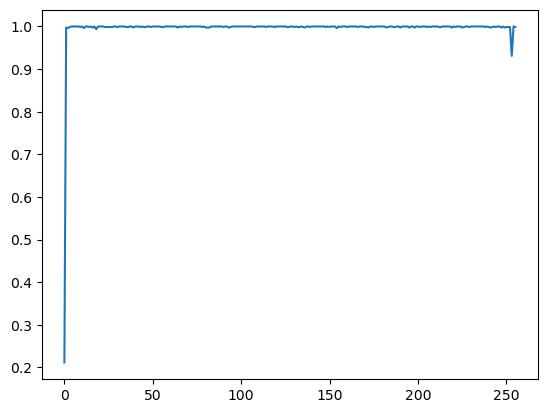

In [32]:
plt.plot(1 - (hist.hist / (28 * 28)))

In [33]:
x = training_data.data[0] / 255.0 / 2
print(x.shape)
print(x.max())
print(x.min())

torch.Size([28, 28])
tensor(0.5000)
tensor(0.)


In [36]:
hist = torch.histogram(x, bins=128, range=(0., 1.))

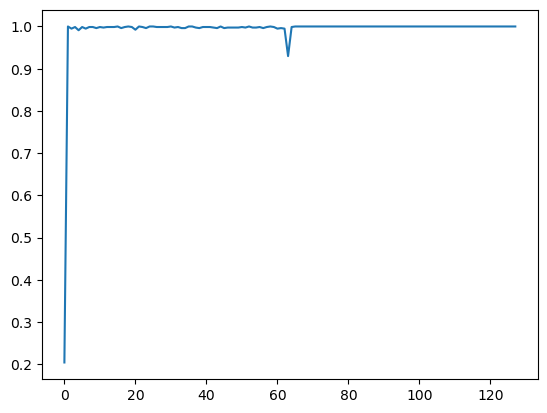

In [37]:
plt.plot(1 - (hist.hist / (28 * 28)))

In [58]:
((torch.rand(1000000)*255).to(int) == 0).sum()

tensor(3867)

In [121]:
x = training_data.data / 255.0
x.shape

torch.Size([60000, 28, 28])

In [105]:
a = lambda x: x.mean() * (x.mean() * (1 - x.mean()) / x.var() - 1)
b = lambda x: (1 - x.mean()) * (x.mean() * (1 - x.mean()) / x.var() - 1)

d = torch.distributions.Beta(a(x), b(x))

In [122]:
print(a(x), b(x))

tensor(0.0257) tensor(0.1709)


In [106]:
d.log_prob(torch.tensor([1e-3]) / 255)

tensor([8.3336])

(array([3.8045844e+07, 2.2896000e+04, 3.3653000e+04, 3.6040000e+04,
        3.8267000e+04, 3.9148000e+04, 3.7692000e+04, 3.8856000e+04,
        3.0878000e+04, 3.8234000e+04, 3.5282000e+04, 3.6020000e+04,
        3.0139000e+04, 4.0100000e+04, 2.6939000e+04, 2.8869000e+04,
        2.9115000e+04, 2.7551000e+04, 2.6849000e+04, 3.4431000e+04,
        2.9955000e+04, 3.5496000e+04, 2.6750000e+04, 2.2910000e+04,
        2.5950000e+04, 2.9995000e+04, 2.4260000e+04, 2.4025000e+04,
        2.5434000e+04, 3.7160000e+04, 2.2913000e+04, 2.6205000e+04,
        2.8890000e+04, 1.5556000e+04, 1.9906000e+04, 2.1516000e+04,
        2.2128000e+04, 2.4760000e+04, 2.5922000e+04, 1.8250000e+04,
        2.0675000e+04, 2.7023000e+04, 2.2349000e+04, 2.1227000e+04,
        1.9030000e+04, 2.1122000e+04, 1.7326000e+04, 2.4237000e+04,
        2.0083000e+04, 1.7919000e+04, 2.3964000e+04, 2.5003000e+04,
        1.4588000e+04, 1.9230000e+04, 1.8195000e+04, 1.8068000e+04,
        2.3511000e+04, 3.1905000e+04, 1.4330000e

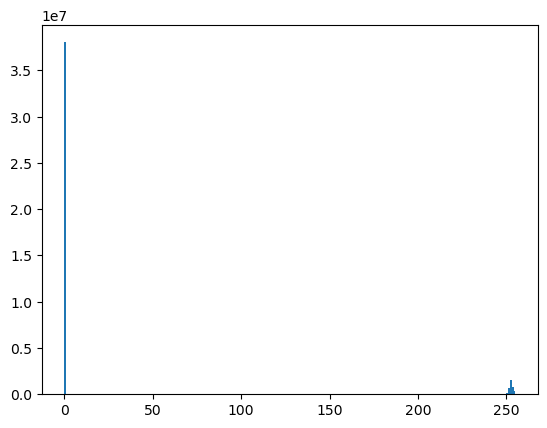

In [120]:
plt.hist(training_data.data.view(-1), bins=256)

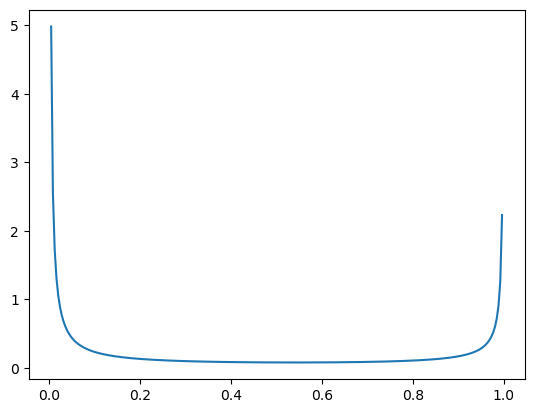

In [107]:
tmp_x = torch.linspace(0, 1, 256)
tmp_y = d.log_prob(tmp_x).exp()
plt.plot(tmp_x, tmp_y)

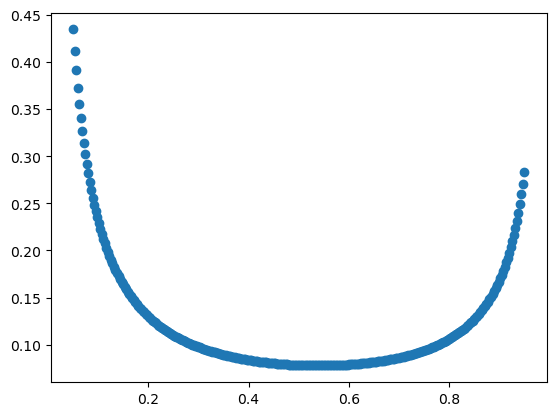

In [162]:
tmp_x_t = torch.linspace(0.05, 0.95, 300)
tmp_y_t = d.log_prob(tmp_x_t).exp()

plt.scatter(tmp_x_t, tmp_y_t)

In [163]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(tmp_x_t.view(-1, 1))

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, tmp_y_t)
print(lin_reg.intercept_ , lin_reg.coef_)

1.0826601216409715 [-2.19724949e+01  2.44611820e+02 -1.63687902e+03  6.99945503e+03
 -1.97381062e+04  3.70857347e+04 -4.59043468e+04  3.59217960e+04
 -1.60981544e+04  3.14744858e+03]


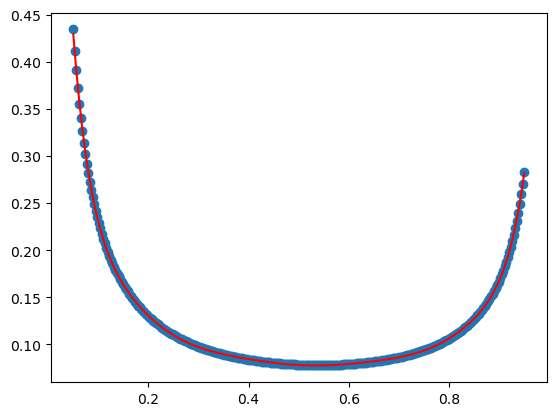

In [164]:
plt.scatter(tmp_x_t, tmp_y_t)

pred_y = lin_reg.predict(X_poly)
plt.plot(tmp_x_t, pred_y, color='r')

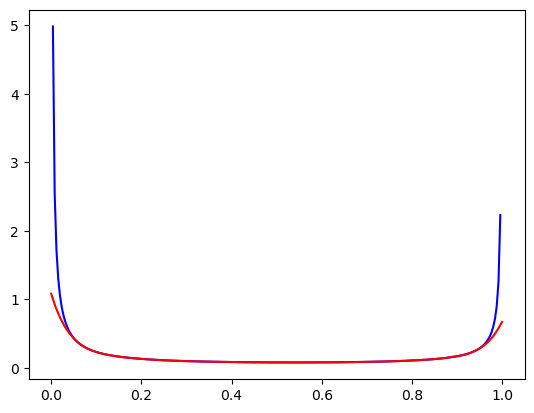

In [165]:
xx = torch.linspace(-0, 1, 100)
yy = torch.zeros_like(xx)
p = 1
for c in lin_reg.coef_:
    yy += c * xx**p
    p += 1
yy += lin_reg.intercept_

tmp_x = torch.linspace(0, 1, 256)
tmp_y = d.log_prob(tmp_x).exp()
plt.plot(tmp_x, tmp_y, color='b')

plt.plot(xx, yy, color='r')

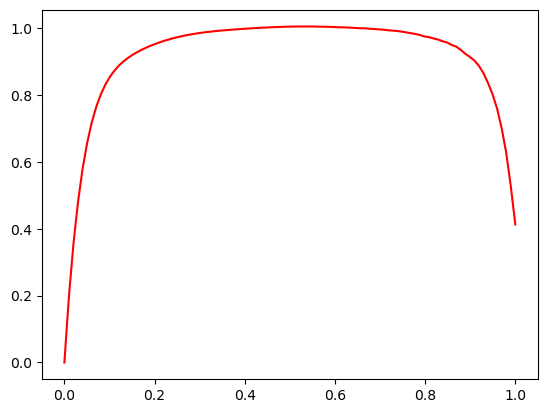

In [166]:
plt.plot(xx, (yy.max() - yy), color='r')

In [167]:
yy.max()

tensor(1.0827)

In [124]:
import matplotlib.pyplot as plt

from myAE import Manager

import torch
from torch import nn
import torch.nn.functional as F

In [125]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.prepare_data()
manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

Now, it is working on cuda:1.


100%|██████████| 30/30 [02:44<00:00,  5.49s/it]


In [128]:
def compare_with_vanilla(manager, name, original_name='vanilla 30'):
    fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

    manager.swap_current_model(original_name)
    manager.model.to('cpu')
    manager.model.eval()

    for x, y in manager.train_dataloader:
        with torch.no_grad():
            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        
        with torch.no_grad():
            manager.swap_current_model(name)

            manager.model.to('cpu')
            manager.model.eval()

            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        
        break
    plt.tight_layout()

Now, it is working on cuda:1.


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:07<00:00,  6.25s/it]


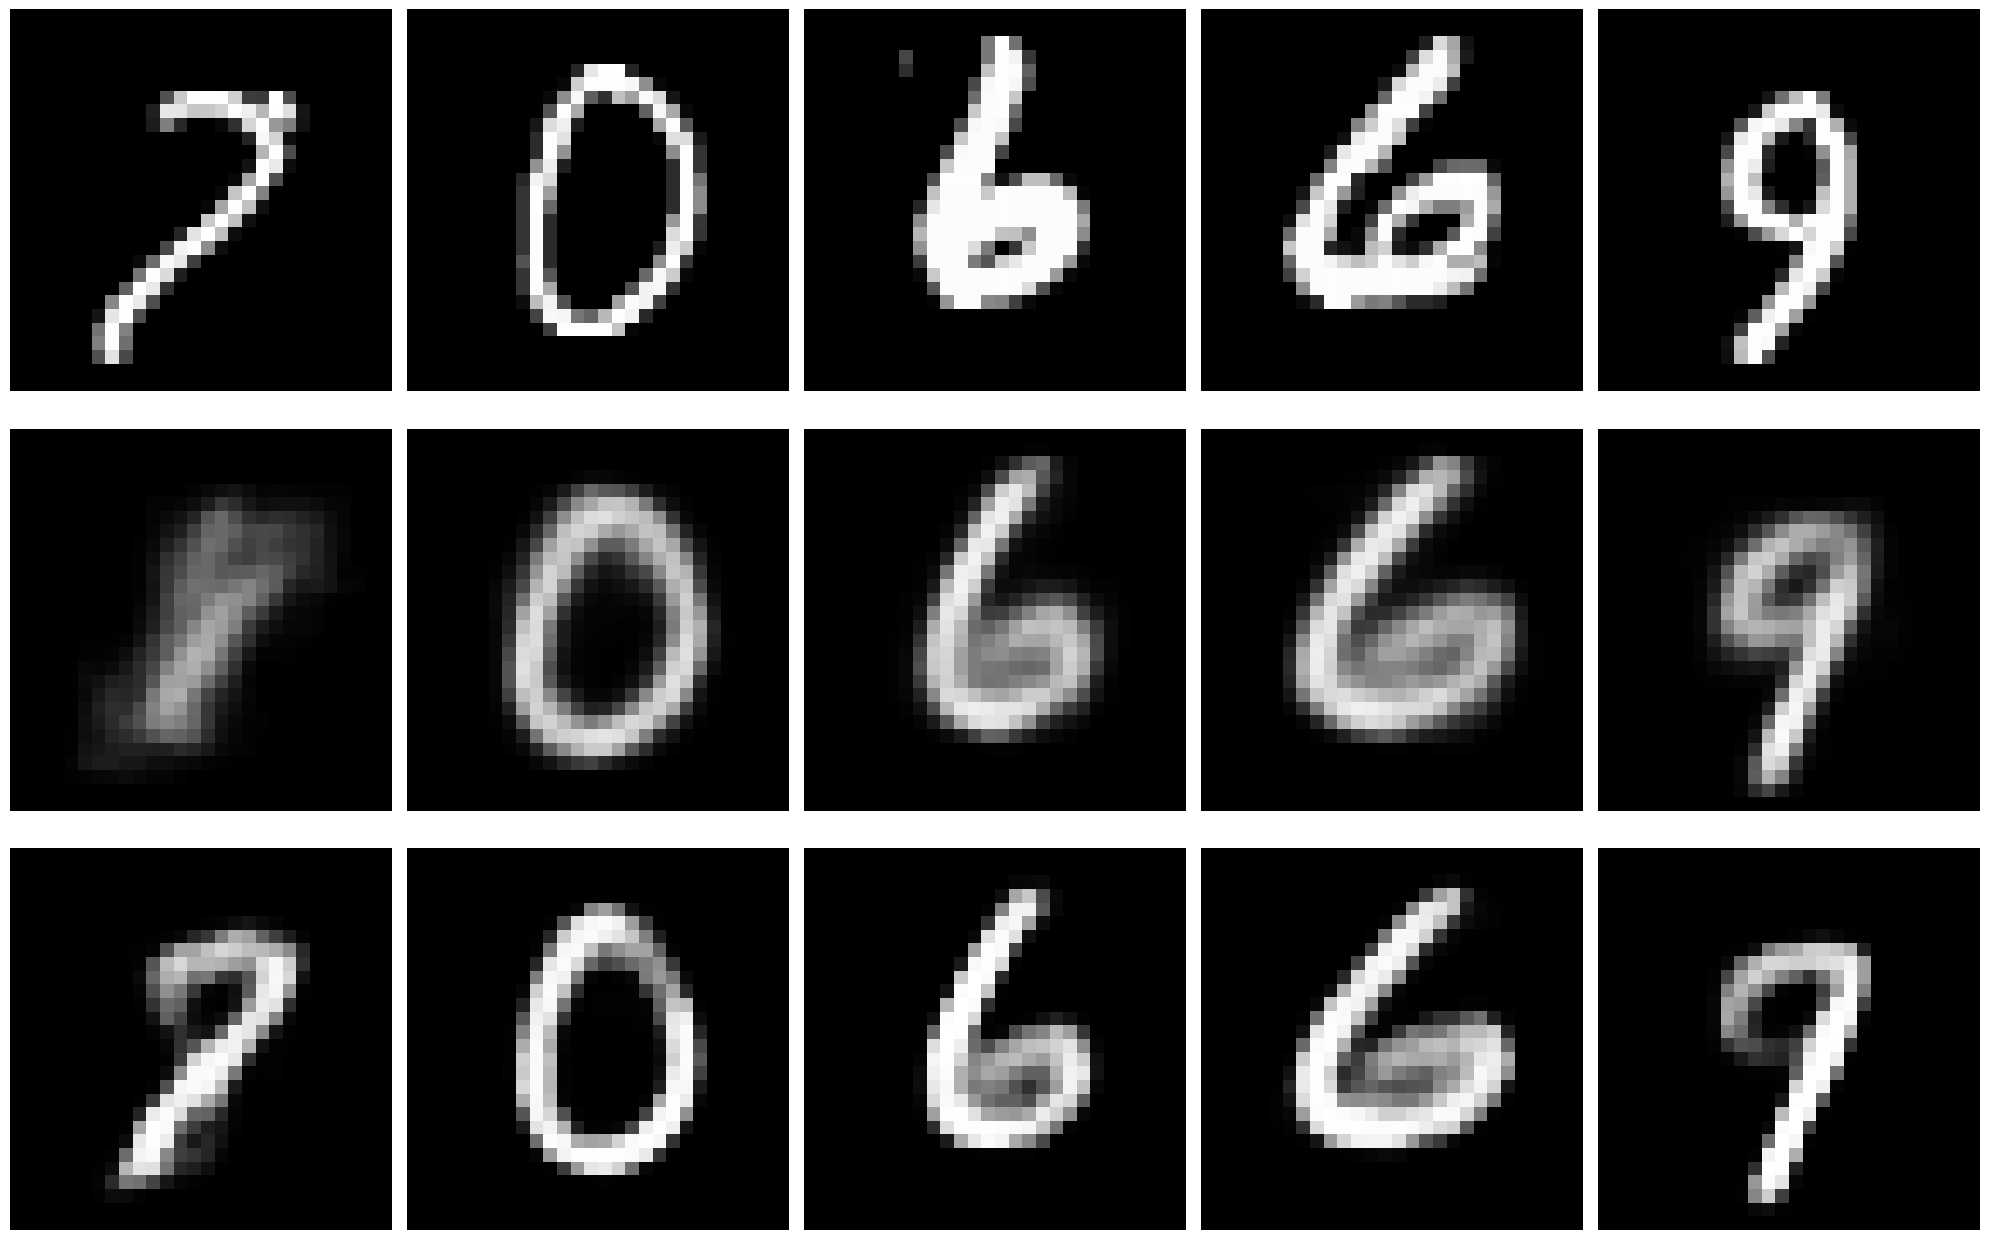

In [168]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)

    pe = torch.zeros_like(pred)
    p = 1
    for c in lin_reg.coef_:
        pe += c * pred**p
        p += 1
    pe += lin_reg.intercept_
    pe = (1.09 - pe).sum() / len(x)
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
name = 'pe 30'
manager.add_model(name)
compare_with_vanilla(manager, name)

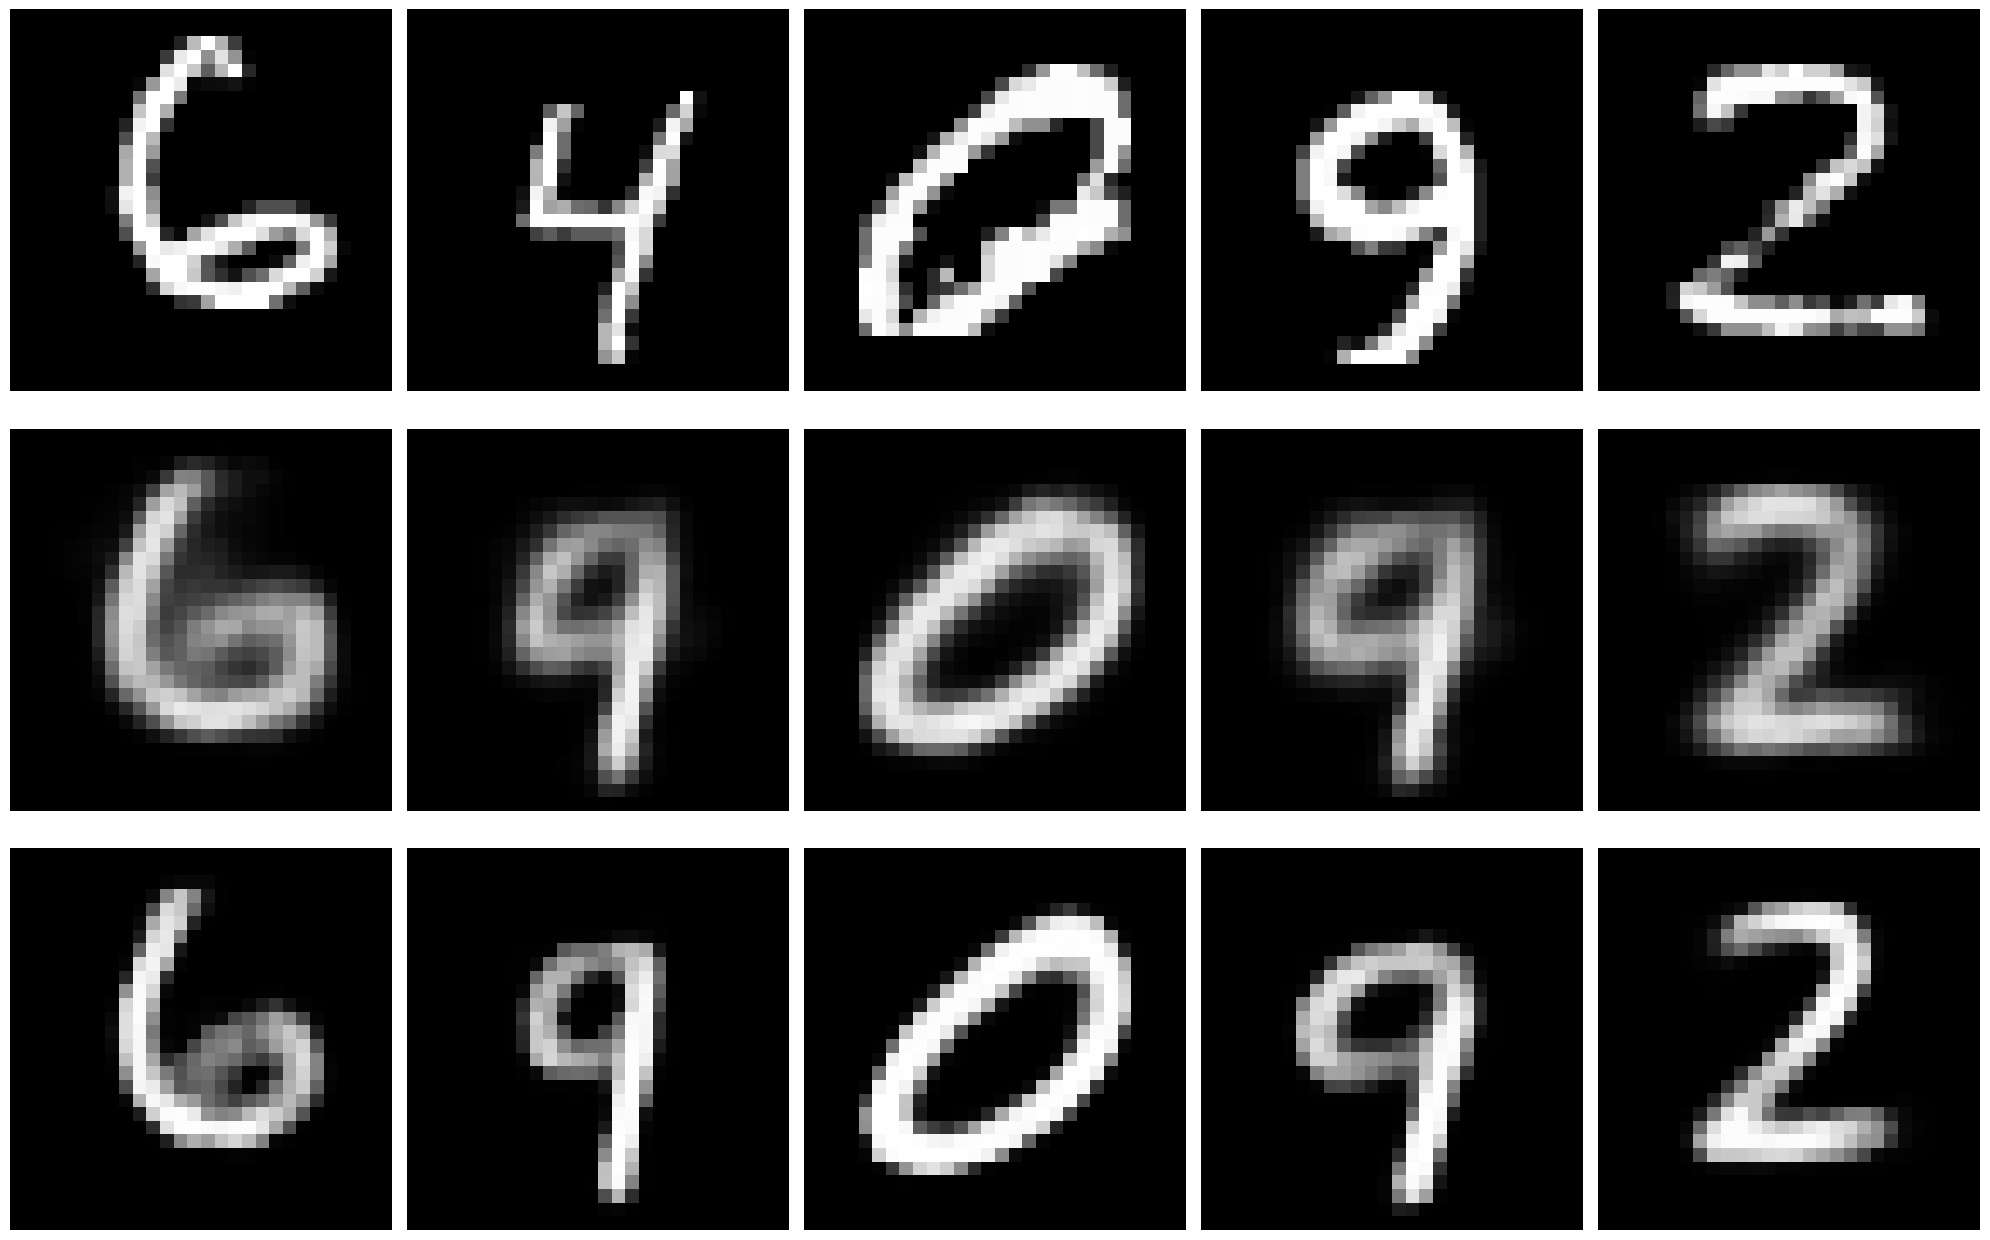

In [169]:
compare_with_vanilla(manager, name)

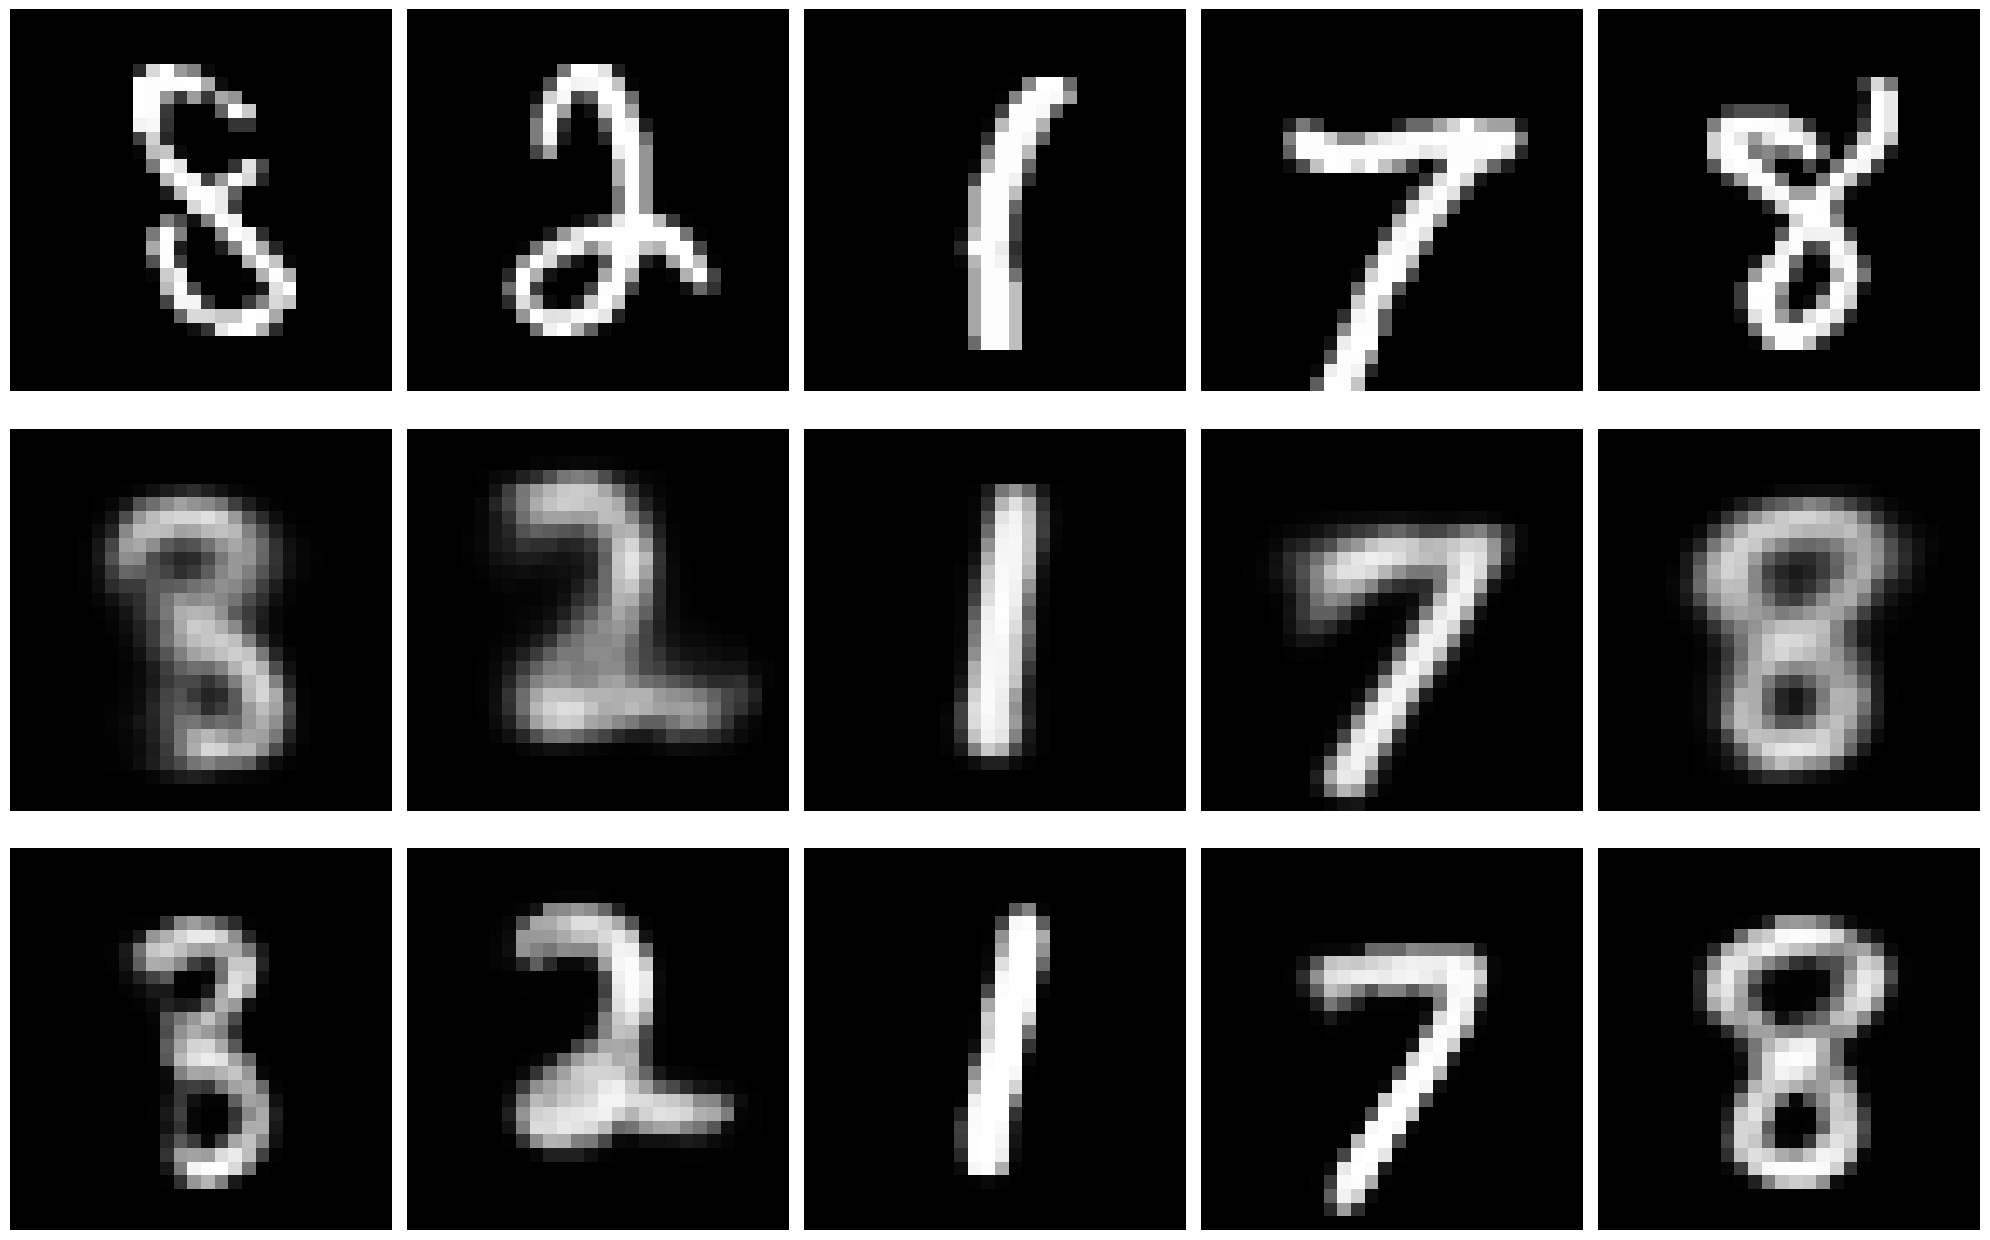

In [188]:
compare_with_vanilla(manager, name)

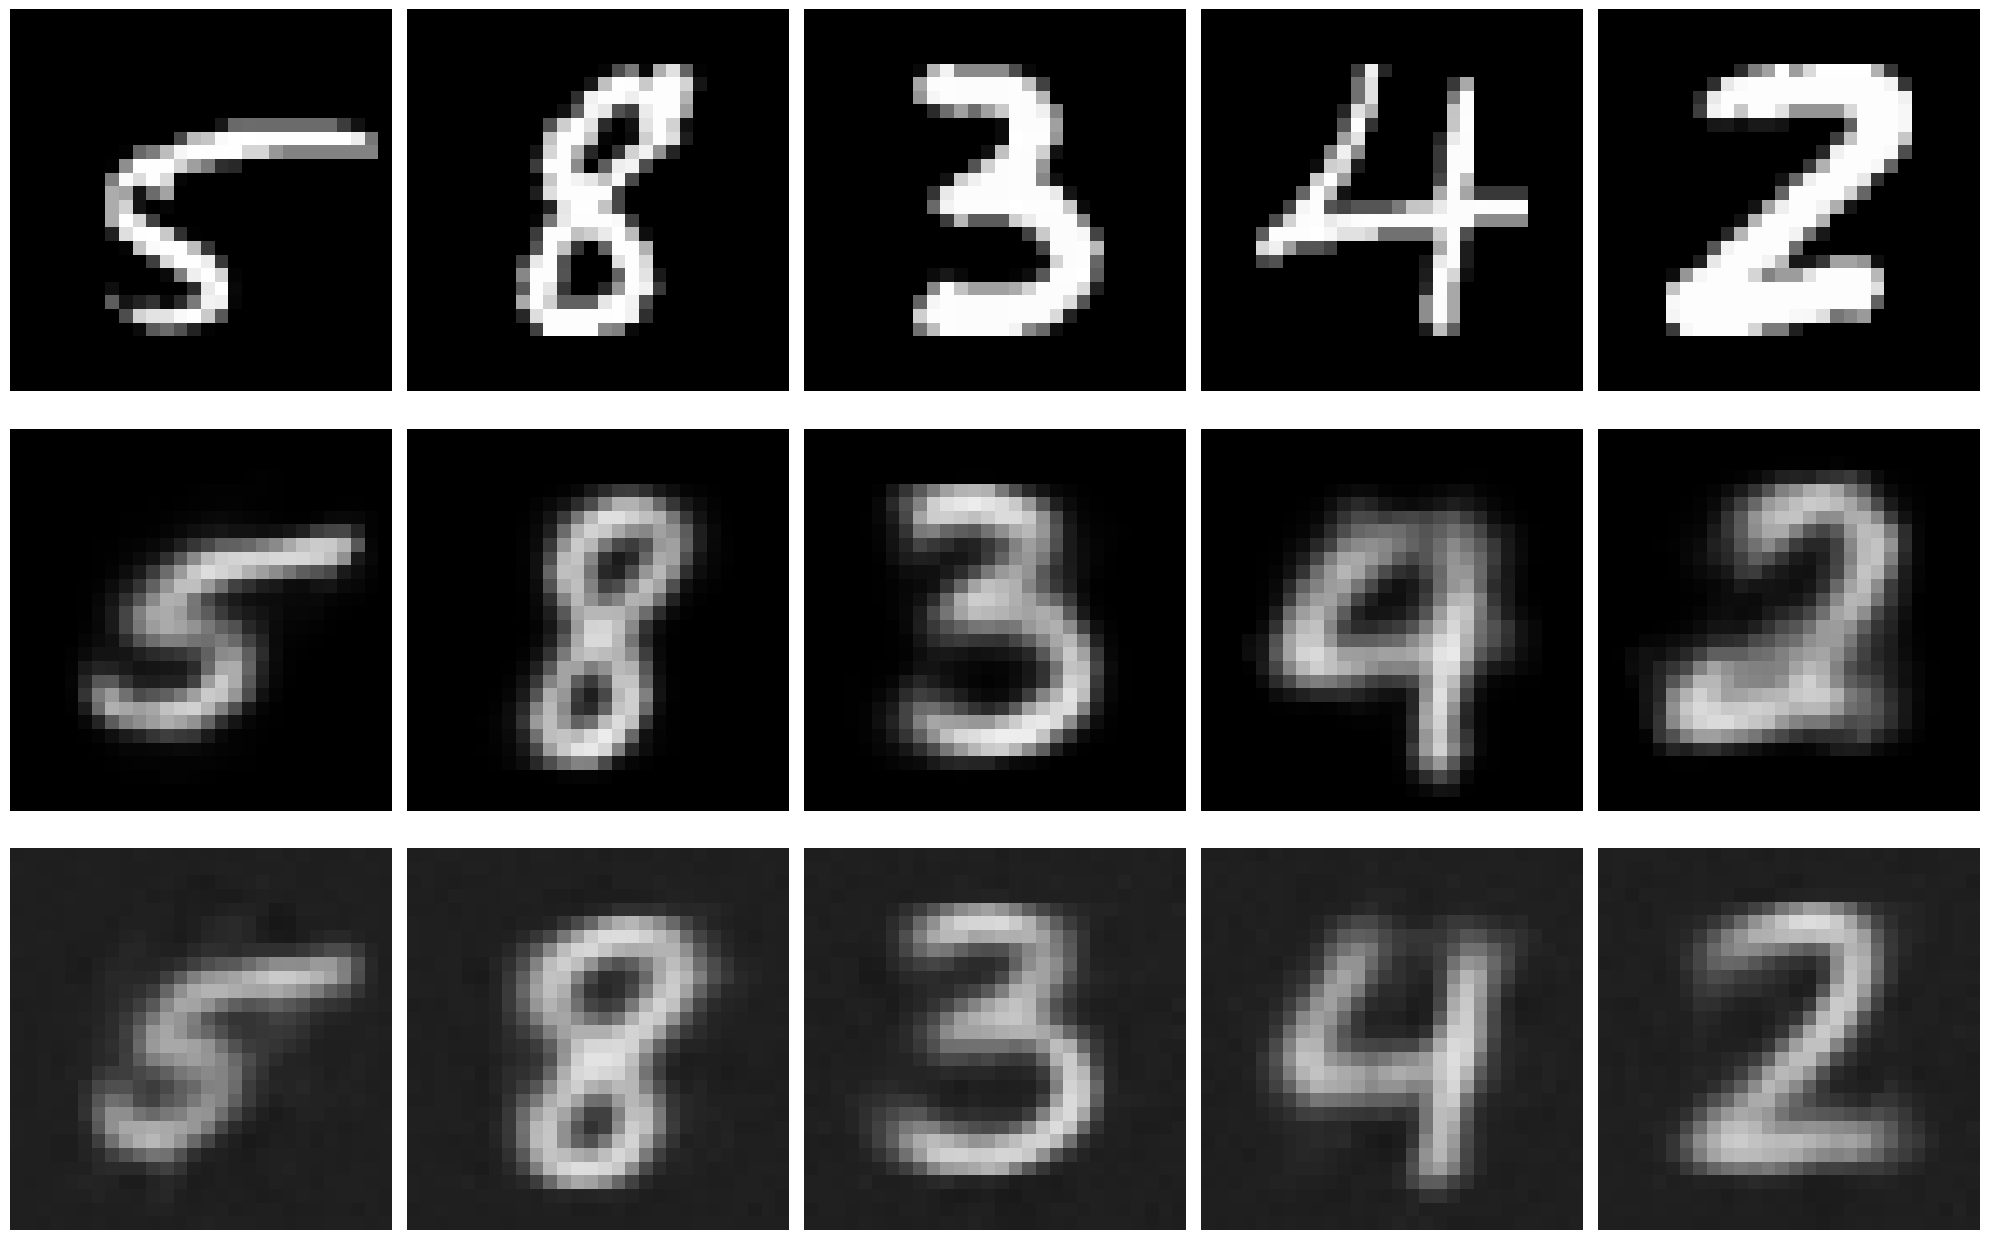

In [134]:
compare_with_vanilla(manager, name)